### Create data

In [1]:
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')
data['Date'] = pd.to_datetime(data['Date'])

test_day_p1 = pd.Timestamp(2018, 4, 1)
end_day_p1 = pd.Timestamp(2018, 9, 30)

test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period1 = data[(data["Date"] <= end_day_p1)].reset_index(drop = True)
train_dataset_p1 = period1[period1["Date"] < test_day_p1].reset_index(drop = True)
test_dataset_p1 = period1[period1["Date"] >= test_day_p1].reset_index(drop = True)
train_dataset_p1 = train_dataset_p1.drop(columns = ["Date"])
test_dataset_p1 = test_dataset_p1.drop(columns = ["Date"])


period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])


print(train_dataset_p1.shape)
print(test_dataset_p1.shape)
print(train_dataset_p2.shape)
print(test_dataset_p2.shape)

(968, 47)
(183, 47)
(2247, 47)
(183, 47)


In [2]:
from Experiment import Experiment
period1_experiment = Experiment(train_dataset=train_dataset_p1, test_dataset=test_dataset_p1)
period2_experiment = Experiment(train_dataset=train_dataset_p2, test_dataset=test_dataset_p2)

X_train_p1, Y_train_p1, X_test_p1, Y_test_p1 = period1_experiment.prepare_data()
X_scaler_p1, Y_scaler_p1 = period1_experiment.X_scaler, period1_experiment.y_scaler
X_train_p2, Y_train_p2, X_test_p2, Y_test_p2 = period2_experiment.prepare_data()
X_scaler_p2, Y_scaler_p2 = period2_experiment.X_scaler, period2_experiment.y_scaler

print(f"X_train_p1 shape: {X_train_p1.shape}, Y_train_p1 shape: {Y_train_p1.shape}, X_test_p1 shape: {X_test_p1.shape}, Y_test_p1 shape: {Y_test_p1.shape}")
print(f"X_train_p2 shape: {X_train_p2.shape}, Y_train_p2 shape: {Y_train_p2.shape}, X_test_p2 shape: {X_test_p2.shape}, Y_test_p2 shape: {Y_test_p2.shape}")

2024-11-25 15:58:33.762933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 15:58:33.982749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 15:58:34.047431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 15:58:36.278574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_train_p1 shape: (967, 1, 47), Y_train_p1 shape: (967,), X_test_p1 shape: (182, 1, 47), Y_test_p1 shape: (182,)
X_train_p2 shape: (2246, 1, 47), Y_train_p2 shape: (2246,), X_test_p2 shape: (182, 1, 47), Y_test_p2 shape: (182,)


In [3]:
import tensorflow as tf
import keras_tuner as kt

def lstm_gru_builder(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(
        shape=(X_train_p2.shape[1], X_train_p2.shape[2])))
    hp_units1 = hp.Choice('lstm_units', values=[32, 64, 128, 256])
    hp_units2 = hp.Choice('gru_units',values=[32, 64, 128, 256])
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)
    hp_activation = hp.Choice('activation', values=['relu'])
    model.add(tf.keras.layers.GRU(units=hp_units2, return_sequences=True, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout1))
    model.add(tf.keras.layers.LSTM(units=hp_units1, return_sequences=False, activation=hp_activation))
    model.add(tf.keras.layers.Dropout(hp_dropout2))
    model.add(tf.keras.layers.Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3])
    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate), loss='mse')
    return model


tuner = kt.Hyperband(lstm_gru_builder,
                     objective='val_loss',
                     max_epochs=1000,
                     factor=5,
                     directory='/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/experiments/hyperparam_tuning',
                     project_name='gru_lstm_p2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

I0000 00:00:1732525119.026017  204652 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732525119.439565  204652 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732525119.439893  204652 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732525119.445541  204652 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
tuner.search(X_train_p2, Y_train_p2, epochs=1000, callbacks=[stop_early], validation_data=(X_test_p2, Y_test_p2))
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 342 Complete [00h 00m 22s]
val_loss: 0.0033839039970189333

Best val_loss So Far: 0.0017273209523409605
Total elapsed time: 01h 38m 56s


In [5]:
print(best_hps.values)

{'lstm_units': 64, 'gru_units': 256, 'dropout1': 0.5, 'dropout2': 0.1, 'activation': 'relu', 'learning_rate': 0.001, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_p2, Y_train_p2, epochs=1000, validation_data=(X_test_p2, Y_test_p2), callbacks=[stop_early])

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0278 - val_loss: 0.0160
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0132
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0079
Epoch 10/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 11/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 12/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

In [8]:
hyper_model = tuner.hypermodel.build(best_hps)
hyper_model.fit(X_train_p2, Y_train_p2, epochs=best_epoch)

Epoch 1/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0296
Epoch 2/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 3/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 4/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 5/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 6/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 7/7
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015


In [9]:
# Evaluate the model on the test dataset
test_loss = hyper_model.evaluate(X_test_p2, Y_test_p2)
print(f"Test loss: {test_loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0077
Test loss: 0.006330652628093958


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


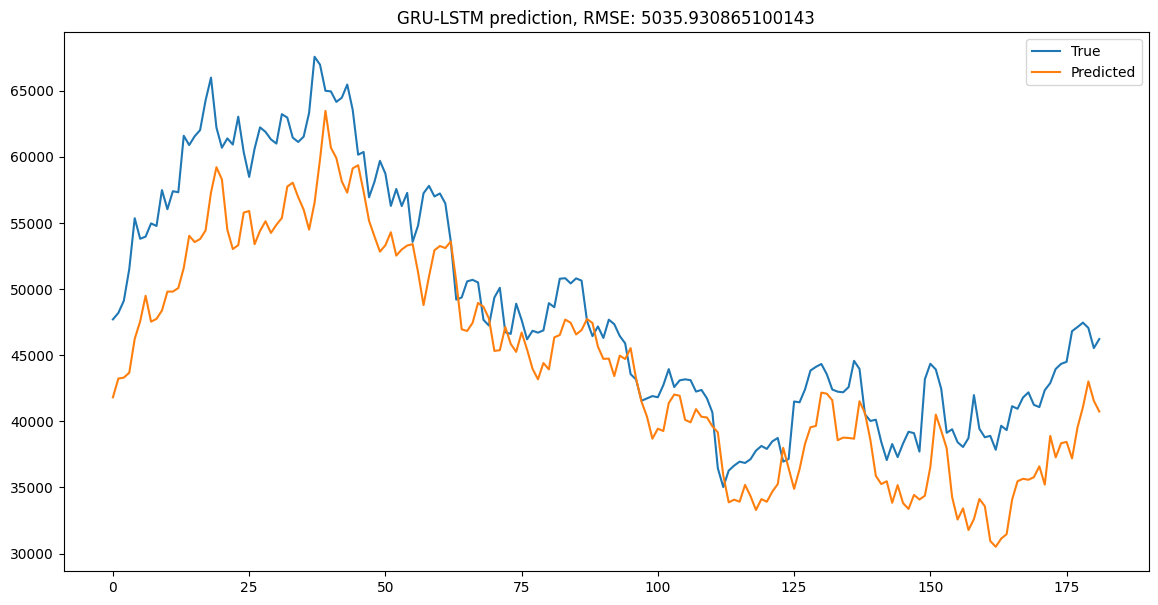

In [10]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

Y_test_p2 = Y_scaler_p2.inverse_transform(Y_test_p2.reshape(-1, 1))
Y_pred = hyper_model.predict(X_test_p2)
Y_pred = Y_scaler_p2.inverse_transform(Y_pred)

rmse = root_mean_squared_error(Y_test_p2, Y_pred)
plt.figure(figsize=(14, 7))
plt.plot(Y_test_p2, label='True')
plt.plot(Y_pred, label='Predicted')
plt.title(f'GRU-LSTM prediction, RMSE: {rmse}')
plt.legend()
plt.show()